# NLP Case Study - Automatic Ticket Classification

In [ ]:
# connect with drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wordcloud

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import json
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
from nltk import ngrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import warnings
import string
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## 1. Data Reading/Data Understanding

In [ ]:
# data reading
file_path = '/content/drive/MyDrive/complaints-2021-05-14_08_16.json'
with open(file_path, 'r') as file:
  json_data = json.load(file)
  data = pd.json_normalize(json_data)

In [ ]:
# data shape
data.shape

(78313, 22)

In [ ]:
# few rows of data
data.head(2)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided


In [ ]:
# null values in data
data.isnull().mean()*100

,0
_index,0.000000
_type,0.000000
_id,0.000000
_score,0.000000
_source.tags,86.081493
_source.zip_code,8.628197
_source.complaint_id,0.000000
_source.issue,0.000000
_source.date_received,0.000000
_source.state,2.542362


In [ ]:
# print columns in data
data.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

## 2. Data Cleaning

In [ ]:
# remove unnecessary columns
data = data[['_source.complaint_id', '_source.complaint_what_happened']]

In [ ]:
# assign new column names
data.rename(columns={'_source.complaint_id': 'id', '_source.complaint_what_happened': 'text'}, inplace = True)

In [ ]:
# print updated data
data.head(2)

,id,text
0,3211475,
1,3229299,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.


In [ ]:
# assign nan in place of blanks in the complaints column
data['text'] = data['text'].apply(lambda x: None if len(x) == 0 else x)
data.head(2)

,id,text
0,3211475,None
1,3229299,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.


In [ ]:
# remove all rows where complaints column is nan
data = data[~data['text'].isnull()]

In [ ]:
# updated data shape
data.shape

(21072, 2)

## 3. Data Preprocessing

In [ ]:
# function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = re.sub('X+', '', text)
  text = re.sub('//', '', text)
  text = text.lower()
  text = re.sub(r'\[.*?\]', '', text)
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub(r'\w*\d\w*', '', text)
  return text

In [ ]:
# clean the text
data['text'] = data['text'].apply(lambda x: clean_text(x))

In [ ]:
# function to Lemmatize the texts
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  return lemmatizer.lemmatize(text)

In [ ]:
# creating a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame({
    'id': data['id'],
    'complaints': data['text'],
})

In [ ]:
# lemmatize the text
df_clean['lemmatize_complaints'] = data['text'].apply(lambda x: lemmatize_text(x))

In [ ]:
# print 2 rows of df_clean
df_clean.head(2)

,id,complaints,lemmatize_complaints
1,3229299,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help
2,3199379,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me


In [ ]:
# function to extract the POS tags
nlp = spacy.load('en_core_web_sm')

def get_pos_tag(text):
  tokens = nlp(text)
  nouns = [tok.text for tok in tokens if tok.tag_ == 'NN']
  return ' '.join(nouns)

In [ ]:
# this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean['complaint_POS_removed'] = df_clean['lemmatize_complaints'].progress_apply(lambda x: get_pos_tag(x))

100%|██████████| 21072/21072 [12:28<00:00, 28.14it/s]


In [ ]:
df_clean.head(2)

,id,complaints,lemmatize_complaints,complaint_POS_removed
1,3229299,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help
2,3199379,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,card agent anniversary date agent information order account anniversary date consent recording agent


## 4. Exploratory Data Analysis (EDA)

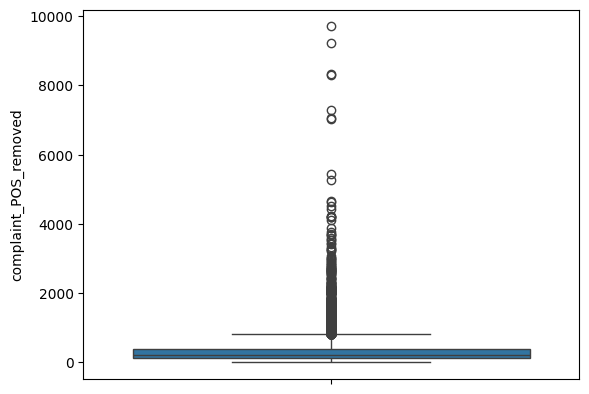

In [ ]:
# visualise the data according to the 'Complaint' character length
char_len = df_clean['complaint_POS_removed'].str.len()
sns.boxplot(char_len)
plt.show()

### Find the top 40 words by frequency among all the articles after processing the text.

In [ ]:
# using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
articles = ' '.join(df_clean['complaint_POS_removed'])                  # combine all complaints in a article
articles = re.sub(r'[^\w\s]', '', articles)                             # remove puntuation
tokens = articles.split()                                               # split into words
articles = [word.lower() for word in tokens if word not in stopwords]   # convert to lower case and remove stop words
word_freq = Counter(articles)                                           # count frequencies
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate_from_frequencies(word_freq)

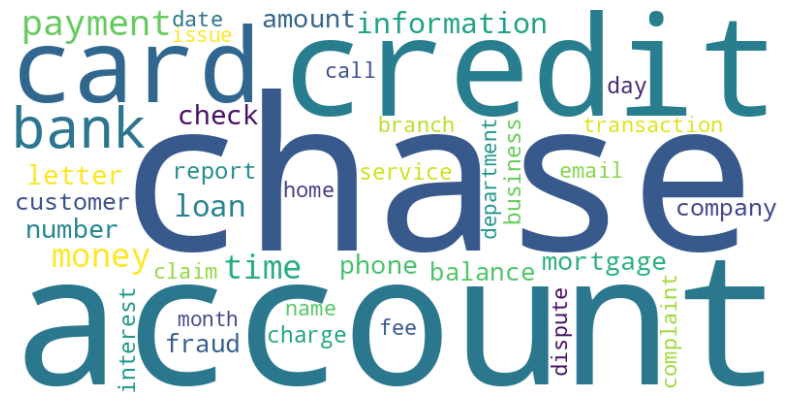

In [ ]:
# plot the WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes
plt.show()

In [ ]:
# removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
# function to compute n-grams and get their top frequencies
def get_top_ngrams(tokens, n, top_k):
    # Generate n-grams
    n_grams = ngrams(tokens, n)

    # Count n-gram frequencies
    ngram_freq = Counter(n_grams)

    # Get the top K n-grams
    return ngram_freq.most_common(top_k)

In [ ]:
text_corpus = ' '.join(df_clean['Complaint_clean'])

In [ ]:
# top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
word_tokens = word_tokenize(text_corpus)
unigrams = get_top_ngrams(word_tokens, 1, 30)

In [ ]:
# top 10 words in the unigram frequency
unigrams[:10]

[(('chase',), 55154),
 (('account',), 41559),
 (('credit',), 32238),
 (('card',), 26705),
 (('bank',), 20879),
 (('payment',), 13965),
 (('time',), 11970),
 (('money',), 11942),
 (('loan',), 9976),
 (('information',), 9640)]

In [ ]:
# top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
word_tokens = word_tokenize(text_corpus)
bigrams = get_top_ngrams(word_tokens, 2, 30)

In [ ]:
# top 10 words in the bigram frequency
bigrams[:10]

[(('credit', 'card'), 11060),
 (('chase', 'credit'), 3548),
 (('account', 'chase'), 3476),
 (('chase', 'account'), 3316),
 (('credit', 'report'), 3271),
 (('account', 'account'), 3074),
 (('customer', 'service'), 3025),
 (('bank', 'account'), 2557),
 (('chase', 'bank'), 2291),
 (('chase', 'chase'), 2029)]

In [ ]:
# top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
word_tokens = word_tokenize(text_corpus)
trigrams = get_top_ngrams(word_tokens, 3, 30)

In [ ]:
# top 10 words in the trigram frequency
trigrams[:10]

[(('chase', 'credit', 'card'), 1923),
 (('credit', 'card', 'account'), 882),
 (('credit', 'card', 'chase'), 858),
 (('credit', 'card', 'company'), 815),
 (('credit', 'card', 'credit'), 665),
 (('card', 'credit', 'card'), 490),
 (('account', 'chase', 'account'), 429),
 (('credit', 'report', 'credit'), 399),
 (('account', 'credit', 'card'), 397),
 (('chase', 'checking', 'account'), 395)]

## 5. Feature Extraction

In [ ]:
# initialise the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)

In [ ]:
# create document term matrix
doc_term_mat = vectorizer.fit_transform(df_clean['Complaint_clean'])

In [ ]:
# content of document term matrix along with the complaint id
pd.DataFrame(doc_term_mat.toarray(), columns=vectorizer.get_feature_names_out(), index=df_clean['id'])

,aarp,ability,absence,abuse,ac,acceleration,accent,acceptance,access,accessory,...,yard,year,yes,yesterday,yield,yr,yrs,zip,zombie,zone
id,,,,,,,,,,,,,,,,,,,,,
3229299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3199379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3233499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3180294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3224980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3094545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.157456,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3091984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.062207,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3133355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## 6. Topic Modelling using NMF

In [ ]:
# define number of topics
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [ ]:
# compute W and H matrices
W = nmf_model.fit_transform(doc_term_mat)   # Document-topic matrix
H = nmf_model.components_                   # Topic-term matrix

In [ ]:
# Top 15 words per topic

words = np.array(vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)],
                           columns=[f'Word {i}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,bank,money,check,chase,branch,deposit,checking,number,business,fraud,transaction,claim,information,day
Topic 1,card,chase,credit,charge,fraud,dispute,company,merchant,fee,purchase,service,time,phone,letter,number
Topic 2,loan,mortgage,chase,home,modification,property,foreclosure,letter,house,time,rate,sale,information,process,escrow
Topic 3,credit,report,inquiry,score,debt,reporting,account,information,limit,identity,card,company,theft,bureaus,history
Topic 4,payment,balance,month,fee,statement,date,chase,auto,time,day,error,car,account,history,transfer


In [ ]:
# create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
result = pd.DataFrame(W, columns=[f'{i}' for i in range(0, num_topics)], index=df_clean['id'])
result.head()

,0,1,2,3,4
id,,,,,
3229299,0.025120,0.000000,0.016714,0.015153,0.011530
3199379,0.008741,0.017268,0.002039,0.000601,0.003752
3233499,0.000000,0.023571,0.000000,0.032075,0.000000
3180294,0.019547,0.023197,0.013311,0.048092,0.001066
3224980,0.065980,0.009103,0.009934,0.000000,0.000000


In [ ]:
# assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = np.array(result.apply(lambda x: x.idxmax(), axis=1))

In [ ]:
df_clean.head(2)

,id,complaints,lemmatize_complaints,complaint_POS_removed,Complaint_clean,Topic
1,3229299,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help,0
2,3199379,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,1


In [ ]:
# print the first 5 Complaint for each of the Topics
df_clean_2=df_clean.groupby('Topic').head(5)
df_clean_2.sort_values('Topic')[['complaints', 'Topic']]

,complaints,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,0
24,mishandling of this account by chase auto and,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number claim number is with chase,0
27,i opened an account with chase bank on and used a code for bonus i called to follow up on about the terms and was told everything was on the account and once i made direct deposit the bonus would be paid out in days as of i had made the required deposits and was told my account never had the coupon code applied and it was past the days to do so so no bonus would be paid,0
32,my chase amazon card was declined for a catering order i had placed for my brothers funeral in the amount of i contacted chase around noon today and was asked the last numbers of my chase savings account and the other user on my account i responded that i did not have a savings and i am only authorized user customer rep told me they would call me back in minutes to keep the line open i didnt receive a call back after an hour so 

In [ ]:
# create the dictionary of Topic names and Topics
topic_names = {
  '0': 'Bank account services',
  '1': 'Credit card / Prepaid card',
  '2': 'Mortgages/loans',
  '3': 'Theft/Dispute reporting',
  '4': 'Others '
}

# replace Topics with Topic Names
df_clean['Topic_cat'] = np.array(df_clean['Topic'].progress_apply(lambda x: topic_names[x]))

100%|██████████| 21072/21072 [00:00<00:00, 1007068.82it/s]


In [ ]:
df_clean.head()

,id,complaints,lemmatize_complaints,complaint_POS_removed,Complaint_clean,Topic,Topic_cat
1,3229299,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account thanks in advance for your help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help,0,Bank account services
2,3199379,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,1,Credit card / Prepaid card
10,3233499,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,card application identity consent credit identity applicant,card application identity consent credit identity applicant,3,Theft/Dispute reporting
11,3180294,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this info

## 7. Model building using supervised learning

In [ ]:
# build training data
train_data = df_clean[['Complaint_clean', 'Topic']]
train_data.head()

,Complaint_clean,Topic
1,morning name stop bank cardmember debt verification statement bank debt mail month debt right information consumer chase account advance help,0
2,card agent anniversary date agent information order account anniversary date consent recording agent,1
10,card application identity consent credit identity applicant,3
11,ticket offer ticket card information offer minute screen decision bank chase bank notification screen representative application information offer credit offer account statement ticket account application representative application request application representative chase fact credit account name credit report chase information credit report application error,3
14,son check chase account fund chase bank account money son check money chase bank money son chase check owner country time date check number claim number chase,0


In [ ]:
# create X and y
X = doc_term_mat
y = df_clean['Topic']

In [ ]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=100)

In [ ]:
# check class balance
y.value_counts()

,count
Topic,
1,6021
0,5964
2,3785
3,2984
4,2318


## 8. Model training and evaluation

- Logistic regression
- Decision Tree
- Random Forest
- Naive Bayes (optional)

In [ ]:
# utility to train the model
def train_model(params, estimator, X_tr, y_tr):
  # define grid search
  grid_search = GridSearchCV(estimator=estimator, param_grid=params, scoring='f1_weighted', cv=4, n_jobs=-1)

  # fit data into grid search
  grid_search.fit(X_tr, y_tr)

  # return best model
  print('Best Params:')
  print(grid_search.best_params_)
  return grid_search.best_estimator_

In [ ]:
# utility to test the model
def test_model(model, X_te, y_te):
  # predictions
  pred = model.predict(X_te)

  # accuracy
  print('Accuracy of model:', round(accuracy_score(y_te, pred), 4))

  # confusion matrix
  print('\nConfusion matrix:')
  print(confusion_matrix(y_te, pred))

  # precision
  print('\nPrecision score:', round(precision_score(y_te, pred, average='weighted'), 4))

  # recall
  print('\nRecall score:', round(recall_score(y_te, pred, average='weighted'), 4))

  # f1-score
  print('\nf1-score:', round(f1_score(y_te, pred, average='weighted'), 4))

### Logistic Regression

In [ ]:
# define params
hyper_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1.0],
    'max_iter': [100, 200, 300],
}

# define estimator
estimator = LogisticRegression(multi_class='multinomial')

# train the model
model = train_model(hyper_params, estimator, X_train, y_train)

# eval model on train set
print('\n******** Evaluation on train data ********')
test_model(model, X_train, y_train)

print('\n')

# eval model on test set
print('******** Evaluation on test data ********')
test_model(model, X_test, y_test)

Best Params:
{'C': 1.0, 'max_iter': 100, 'penalty': 'l2'}

******** Evaluation on train data ********
Accuracy of model: 0.9874

Confusion matrix:
[[4756   17    2    4    0]
 [  15 4792    1    9    0]
 [  19   13 3004    7    2]
 [  12   29   11 2323    1]
 [  24   16   24    6 1770]]

Precision score: 0.9875

Recall score: 0.9874

f1-score: 0.9874


******** Evaluation on test data ********
Accuracy of model: 0.958

Confusion matrix:
[[1166   15    1    1    2]
 [  17 1170    6    7    4]
 [  18   12  706    4    0]
 [  10   13    5  576    4]
 [  21   16   19    2  420]]

Precision score: 0.9584

Recall score: 0.958

f1-score: 0.9578


### Decision Tree Classifier

In [ ]:
# define params
hyper_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 11],
    'min_samples_leaf': [10, 20, 30, 40],
}

# define estimator
estimator = DecisionTreeClassifier(random_state=100)

# train the model
model = train_model(hyper_params, estimator, X_train, y_train)

# eval model on train set
print('******** Evaluation on train data ********')
test_model(model, X_train, y_train)

print('\n')

# eval model on test set
print('******** Evaluation on test data ********')
test_model(model, X_test, y_test)

Best Params:
{'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 10}
******** Evaluation on train data ********
Accuracy of model: 0.8806

Confusion matrix:
[[4391  135  169   49   35]
 [ 225 4065  334  172   21]
 [ 129   42 2786   43   45]
 [  84  113  105 2052   22]
 [  83   53  116   37 1551]]

Precision score: 0.8844

Recall score: 0.8806

f1-score: 0.881


******** Evaluation on test data ********
Accuracy of model: 0.8294

Confusion matrix:
[[1018   69   57   20   21]
 [  84  946  102   53   19]
 [  41   15  650   19   15]
 [  27   46   19  504   12]
 [  29   25   30   16  378]]

Precision score: 0.8323

Recall score: 0.8294

f1-score: 0.8295


### Random Forest Classifier

In [ ]:
# define params
hyper_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [15, 20, 25],
    'min_samples_leaf': [5, 10, 20, 30]
}

# define estimator
estimator = RandomForestClassifier(random_state=100, n_jobs=-1)

# train the model
model = train_model(hyper_params, estimator, X_train, y_train)

# eval model on train set
print('******** Evaluation on train data ********')
test_model(model, X_train, y_train)

print('\n')

# eval model on test set
print('******** Evaluation on test data ********')
test_model(model, X_test, y_test)

Best Params:
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 5, 'n_estimators': 300}
******** Evaluation on train data ********
Accuracy of model: 0.8787

Confusion matrix:
[[4576  159   12   28    4]
 [ 244 4534    3   30    6]
 [ 190   66 2755   27    7]
 [ 114  395   41 1814   12]
 [ 269  230  178   30 1133]]

Precision score: 0.8867

Recall score: 0.8787

f1-score: 0.8752


******** Evaluation on test data ********
Accuracy of model: 0.8472

Confusion matrix:
[[1109   59    8    6    3]
 [  86 1105    1   12    0]
 [  57   13  660    7    3]
 [  38  117   16  436    1]
 [  77   79   54    7  261]]

Precision score: 0.8596

Recall score: 0.8472

f1-score: 0.8423


### Naive Byes Classifier

In [ ]:
# define params
hyper_params = {
    'alpha': [0.1, 0.5, 1, 2, 5]
}

# define estimator
estimator = MultinomialNB()

# train the model
model = train_model(hyper_params, estimator, X_train, y_train)

# eval model on train set
print('******** Evaluation on train data ********')
test_model(model, X_train, y_train)

print('\n')

# eval model on test set
print('******** Evaluation on test data ********')
test_model(model, X_test, y_test)

Best Params:
{'alpha': 0.1}
******** Evaluation on train data ********
Accuracy of model: 0.8382

Confusion matrix:
[[4217  345   62  112   43]
 [ 383 4166   27  184   57]
 [ 105   84 2708   75   73]
 [  75  276   75 1892   58]
 [ 241  204  183   66 1146]]

Precision score: 0.8381

Recall score: 0.8382

f1-score: 0.8362


******** Evaluation on test data ********
Accuracy of model: 0.7886

Confusion matrix:
[[999 131  17  28  10]
 [134 982   9  61  18]
 [ 30  22 647  20  21]
 [ 26  78  27 458  19]
 [ 86  73  60  21 238]]

Precision score: 0.7884

Recall score: 0.7886

f1-score: 0.7844


## 9. Model Inference

From above training and evaluation phase we can say that `Logistic Regression` is working well on data, so this we pick this model for our inference.

In [ ]:
# logistic model
log_model = LogisticRegression(C= 1.0, max_iter= 100, penalty= 'l2')

# train data
log_model.fit(X, y)

LogisticRegression()

In [ ]:
example_text = ['I am writing to formally report the theft of my mobile phone that occurred on yesterday at 4 pm in New York location.']
test_data = vectorizer.transform(example_text)
pred = log_model.predict(test_data)

print(topic_names[pred[0]])

Theft/Dispute reporting
